In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [19]:
%%capture
!pip install torchvision

#### Prepare for Dataset

In [20]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


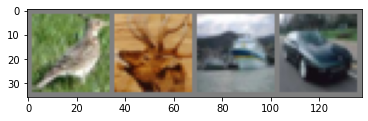

 bird  deer  ship   car


In [22]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [28]:
len(images[0][0][0])

32

#### Choose a Device

In [5]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### 2-Layer CNN

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ###### Fill the blank here ######
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2)

        # Linear layers
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(20 * 8 * 8, 1280)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(1280, 10)
        
        
        
        
        
    def forward(self, x):
        ###### Fill the blank here ######
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)


        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        return x
        
        
        

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1280, out_features=1280, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=1280, out_features=10, bias=True)
)

#### Optimizer and Loss Function

In [7]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

#### Training Procedure

In [12]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

#### Training Loss Curve

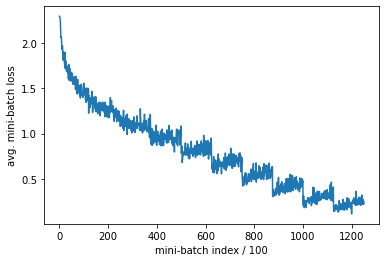

In [91]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

#### Evaluate on Test Dataset

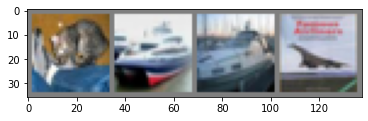

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship plane plane


In [92]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [93]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 65 %


In [94]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 77 %
Accuracy of  bird : 52 %
Accuracy of   cat : 46 %
Accuracy of  deer : 54 %
Accuracy of   dog : 53 %
Accuracy of  frog : 76 %
Accuracy of horse : 67 %
Accuracy of  ship : 74 %
Accuracy of truck : 74 %


# 3-Layer CNN

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        # Linear layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(40 * 4 * 4, 1280)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(1280, 10)
        


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu4(x)
        
        x = self.fc2(x)
        
        return x
net = Net()     
net.to(device)  

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=640, out_features=1280, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=1280, out_features=10, bias=True)
)

In [14]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.Adam(net.parameters(), lr=0.001)

In [15]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.165
[epoch: 0, i:   199] avg mini-batch loss: 2.056
[epoch: 0, i:   299] avg mini-batch loss: 1.990
[epoch: 0, i:   399] avg mini-batch loss: 1.853
[epoch: 0, i:   499] avg mini-batch loss: 1.879
[epoch: 0, i:   599] avg mini-batch loss: 1.849
[epoch: 0, i:   699] avg mini-batch loss: 1.731
[epoch: 0, i:   799] avg mini-batch loss: 1.673
[epoch: 0, i:   899] avg mini-batch loss: 1.757
[epoch: 0, i:   999] avg mini-batch loss: 1.639
[epoch: 0, i:  1099] avg mini-batch loss: 1.586
[epoch: 0, i:  1199] avg mini-batch loss: 1.687
[epoch: 0, i:  1299] avg mini-batch loss: 1.667
[epoch: 0, i:  1399] avg mini-batch loss: 1.556
[epoch: 0, i:  1499] avg mini-batch loss: 1.573
[epoch: 0, i:  1599] avg mini-batch loss: 1.666
[epoch: 0, i:  1699] avg mini-batch loss: 1.651
[epoch: 0, i:  1799] avg mini-batch loss: 1.604
[epoch: 0, i:  1899] avg mini-batch loss: 1.458
[epoch: 0, i:  1999] avg mini-batch loss: 1.495
[epoch: 0, i:  2099] avg mini-batch loss

[epoch: 1, i:  4699] avg mini-batch loss: 0.995
[epoch: 1, i:  4799] avg mini-batch loss: 1.034
[epoch: 1, i:  4899] avg mini-batch loss: 1.063
[epoch: 1, i:  4999] avg mini-batch loss: 1.104
[epoch: 1, i:  5099] avg mini-batch loss: 1.054
[epoch: 1, i:  5199] avg mini-batch loss: 1.129
[epoch: 1, i:  5299] avg mini-batch loss: 1.001
[epoch: 1, i:  5399] avg mini-batch loss: 1.071
[epoch: 1, i:  5499] avg mini-batch loss: 1.040
[epoch: 1, i:  5599] avg mini-batch loss: 1.113
[epoch: 1, i:  5699] avg mini-batch loss: 1.109
[epoch: 1, i:  5799] avg mini-batch loss: 1.038
[epoch: 1, i:  5899] avg mini-batch loss: 1.107
[epoch: 1, i:  5999] avg mini-batch loss: 1.094
[epoch: 1, i:  6099] avg mini-batch loss: 1.190
[epoch: 1, i:  6199] avg mini-batch loss: 1.025
[epoch: 1, i:  6299] avg mini-batch loss: 1.021
[epoch: 1, i:  6399] avg mini-batch loss: 1.039
[epoch: 1, i:  6499] avg mini-batch loss: 1.005
[epoch: 1, i:  6599] avg mini-batch loss: 1.065
[epoch: 1, i:  6699] avg mini-batch loss

[epoch: 2, i:  9299] avg mini-batch loss: 0.954
[epoch: 2, i:  9399] avg mini-batch loss: 0.945
[epoch: 2, i:  9499] avg mini-batch loss: 0.910
[epoch: 2, i:  9599] avg mini-batch loss: 0.927
[epoch: 2, i:  9699] avg mini-batch loss: 0.907
[epoch: 2, i:  9799] avg mini-batch loss: 0.981
[epoch: 2, i:  9899] avg mini-batch loss: 0.913
[epoch: 2, i:  9999] avg mini-batch loss: 0.920
[epoch: 2, i: 10099] avg mini-batch loss: 0.948
[epoch: 2, i: 10199] avg mini-batch loss: 0.826
[epoch: 2, i: 10299] avg mini-batch loss: 0.960
[epoch: 2, i: 10399] avg mini-batch loss: 1.011
[epoch: 2, i: 10499] avg mini-batch loss: 0.923
[epoch: 2, i: 10599] avg mini-batch loss: 0.936
[epoch: 2, i: 10699] avg mini-batch loss: 0.846
[epoch: 2, i: 10799] avg mini-batch loss: 0.915
[epoch: 2, i: 10899] avg mini-batch loss: 0.969
[epoch: 2, i: 10999] avg mini-batch loss: 0.891
[epoch: 2, i: 11099] avg mini-batch loss: 0.883
[epoch: 2, i: 11199] avg mini-batch loss: 0.909
[epoch: 2, i: 11299] avg mini-batch loss

[epoch: 4, i:  1399] avg mini-batch loss: 0.754
[epoch: 4, i:  1499] avg mini-batch loss: 0.707
[epoch: 4, i:  1599] avg mini-batch loss: 0.782
[epoch: 4, i:  1699] avg mini-batch loss: 0.765
[epoch: 4, i:  1799] avg mini-batch loss: 0.656
[epoch: 4, i:  1899] avg mini-batch loss: 0.735
[epoch: 4, i:  1999] avg mini-batch loss: 0.699
[epoch: 4, i:  2099] avg mini-batch loss: 0.759
[epoch: 4, i:  2199] avg mini-batch loss: 0.725
[epoch: 4, i:  2299] avg mini-batch loss: 0.760
[epoch: 4, i:  2399] avg mini-batch loss: 0.714
[epoch: 4, i:  2499] avg mini-batch loss: 0.770
[epoch: 4, i:  2599] avg mini-batch loss: 0.753
[epoch: 4, i:  2699] avg mini-batch loss: 0.728
[epoch: 4, i:  2799] avg mini-batch loss: 0.804
[epoch: 4, i:  2899] avg mini-batch loss: 0.649
[epoch: 4, i:  2999] avg mini-batch loss: 0.826
[epoch: 4, i:  3099] avg mini-batch loss: 0.810
[epoch: 4, i:  3199] avg mini-batch loss: 0.715
[epoch: 4, i:  3299] avg mini-batch loss: 0.672
[epoch: 4, i:  3399] avg mini-batch loss

[epoch: 5, i:  5999] avg mini-batch loss: 0.602
[epoch: 5, i:  6099] avg mini-batch loss: 0.682
[epoch: 5, i:  6199] avg mini-batch loss: 0.684
[epoch: 5, i:  6299] avg mini-batch loss: 0.682
[epoch: 5, i:  6399] avg mini-batch loss: 0.658
[epoch: 5, i:  6499] avg mini-batch loss: 0.635
[epoch: 5, i:  6599] avg mini-batch loss: 0.674
[epoch: 5, i:  6699] avg mini-batch loss: 0.603
[epoch: 5, i:  6799] avg mini-batch loss: 0.680
[epoch: 5, i:  6899] avg mini-batch loss: 0.594
[epoch: 5, i:  6999] avg mini-batch loss: 0.754
[epoch: 5, i:  7099] avg mini-batch loss: 0.774
[epoch: 5, i:  7199] avg mini-batch loss: 0.657
[epoch: 5, i:  7299] avg mini-batch loss: 0.632
[epoch: 5, i:  7399] avg mini-batch loss: 0.734
[epoch: 5, i:  7499] avg mini-batch loss: 0.670
[epoch: 5, i:  7599] avg mini-batch loss: 0.633
[epoch: 5, i:  7699] avg mini-batch loss: 0.680
[epoch: 5, i:  7799] avg mini-batch loss: 0.693
[epoch: 5, i:  7899] avg mini-batch loss: 0.738
[epoch: 5, i:  7999] avg mini-batch loss

[epoch: 6, i: 10599] avg mini-batch loss: 0.838
[epoch: 6, i: 10699] avg mini-batch loss: 0.664
[epoch: 6, i: 10799] avg mini-batch loss: 0.632
[epoch: 6, i: 10899] avg mini-batch loss: 0.680
[epoch: 6, i: 10999] avg mini-batch loss: 0.715
[epoch: 6, i: 11099] avg mini-batch loss: 0.708
[epoch: 6, i: 11199] avg mini-batch loss: 0.689
[epoch: 6, i: 11299] avg mini-batch loss: 0.646
[epoch: 6, i: 11399] avg mini-batch loss: 0.592
[epoch: 6, i: 11499] avg mini-batch loss: 0.621
[epoch: 6, i: 11599] avg mini-batch loss: 0.778
[epoch: 6, i: 11699] avg mini-batch loss: 0.647
[epoch: 6, i: 11799] avg mini-batch loss: 0.581
[epoch: 6, i: 11899] avg mini-batch loss: 0.635
[epoch: 6, i: 11999] avg mini-batch loss: 0.660
[epoch: 6, i: 12099] avg mini-batch loss: 0.558
[epoch: 6, i: 12199] avg mini-batch loss: 0.713
[epoch: 6, i: 12299] avg mini-batch loss: 0.653
[epoch: 6, i: 12399] avg mini-batch loss: 0.653
[epoch: 6, i: 12499] avg mini-batch loss: 0.754
[epoch: 7, i:    99] avg mini-batch loss

[epoch: 8, i:  2699] avg mini-batch loss: 0.452
[epoch: 8, i:  2799] avg mini-batch loss: 0.457
[epoch: 8, i:  2899] avg mini-batch loss: 0.512
[epoch: 8, i:  2999] avg mini-batch loss: 0.567
[epoch: 8, i:  3099] avg mini-batch loss: 0.509
[epoch: 8, i:  3199] avg mini-batch loss: 0.465
[epoch: 8, i:  3299] avg mini-batch loss: 0.481
[epoch: 8, i:  3399] avg mini-batch loss: 0.519
[epoch: 8, i:  3499] avg mini-batch loss: 0.449
[epoch: 8, i:  3599] avg mini-batch loss: 0.523
[epoch: 8, i:  3699] avg mini-batch loss: 0.464
[epoch: 8, i:  3799] avg mini-batch loss: 0.439
[epoch: 8, i:  3899] avg mini-batch loss: 0.428
[epoch: 8, i:  3999] avg mini-batch loss: 0.407
[epoch: 8, i:  4099] avg mini-batch loss: 0.465
[epoch: 8, i:  4199] avg mini-batch loss: 0.419
[epoch: 8, i:  4299] avg mini-batch loss: 0.448
[epoch: 8, i:  4399] avg mini-batch loss: 0.623
[epoch: 8, i:  4499] avg mini-batch loss: 0.456
[epoch: 8, i:  4599] avg mini-batch loss: 0.456
[epoch: 8, i:  4699] avg mini-batch loss

[epoch: 9, i:  7299] avg mini-batch loss: 0.402
[epoch: 9, i:  7399] avg mini-batch loss: 0.388
[epoch: 9, i:  7499] avg mini-batch loss: 0.453
[epoch: 9, i:  7599] avg mini-batch loss: 0.374
[epoch: 9, i:  7699] avg mini-batch loss: 0.473
[epoch: 9, i:  7799] avg mini-batch loss: 0.419
[epoch: 9, i:  7899] avg mini-batch loss: 0.502
[epoch: 9, i:  7999] avg mini-batch loss: 0.460
[epoch: 9, i:  8099] avg mini-batch loss: 0.415
[epoch: 9, i:  8199] avg mini-batch loss: 0.412
[epoch: 9, i:  8299] avg mini-batch loss: 0.375
[epoch: 9, i:  8399] avg mini-batch loss: 0.469
[epoch: 9, i:  8499] avg mini-batch loss: 0.479
[epoch: 9, i:  8599] avg mini-batch loss: 0.501
[epoch: 9, i:  8699] avg mini-batch loss: 0.611
[epoch: 9, i:  8799] avg mini-batch loss: 0.618
[epoch: 9, i:  8899] avg mini-batch loss: 0.402
[epoch: 9, i:  8999] avg mini-batch loss: 0.418
[epoch: 9, i:  9099] avg mini-batch loss: 0.573
[epoch: 9, i:  9199] avg mini-batch loss: 0.571
[epoch: 9, i:  9299] avg mini-batch loss

# Training loss curve

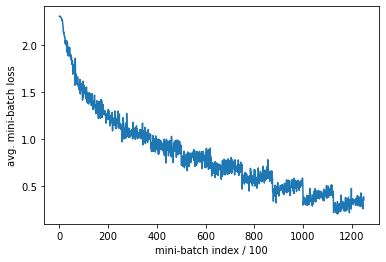

In [98]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

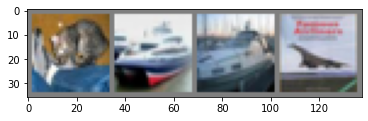

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [99]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

# Test Error Overall

In [100]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 70 %


# Test Error for each class

In [101]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 78 %
Accuracy of   car : 85 %
Accuracy of  bird : 57 %
Accuracy of   cat : 59 %
Accuracy of  deer : 56 %
Accuracy of   dog : 64 %
Accuracy of  frog : 72 %
Accuracy of horse : 75 %
Accuracy of  ship : 82 %
Accuracy of truck : 76 %


# Using Adam

In [16]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 65 %


In [17]:
import torchsummary

In [29]:
torchsummary.summary(net, input_size=(3, 32, 32))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            280
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            1,820
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            7,240
├─ReLU: 1-8                              --
├─MaxPool2d: 1-9                         --
├─Flatten: 1-10                          --
├─Linear: 1-11                           820,480
├─ReLU: 1-12                             --
├─Linear: 1-13                           12,810
Total params: 842,630
Trainable params: 842,630
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            280
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            1,820
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            7,240
├─ReLU: 1-8                              --
├─MaxPool2d: 1-9                         --
├─Flatten: 1-10                          --
├─Linear: 1-11                           820,480
├─ReLU: 1-12                             --
├─Linear: 1-13                           12,810
Total params: 842,630
Trainable params: 842,630
Non-trainable params: 0